# Predicting Melbourne Housing Prices: A Machine Learning Approach

In [41]:
# --- Core Libraries ---
import pandas as pd
import numpy as np
import warnings

# --- Visualization Libraries ---
import matplotlib.pyplot as plt
import seaborn as sns
import shap  # For advanced feature importance

# --- Scikit-learn Preprocessing & Modeling ---
from sklearn.model_selection import train_test_split, KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance

# --- Scikit-learn Metrics ---
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- Notebook Settings ---
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.style.use('seaborn-v0_8-whitegrid')
print("All libraries imported successfully.")

All libraries imported successfully.


In [42]:
# Load the dataset from the specified CSV file
try:
    df = pd.read_csv('final_data_sorted.csv')
    print("Dataset loaded successfully.")
    print(f"Dataset shape: {df.shape[0]} rows and {df.shape[1]} columns")
except FileNotFoundError:
    print("Error: 'final_data_sorted.csv' not found. Please ensure the file is in the same directory.")

Dataset loaded successfully.
Dataset shape: 1659 rows and 19 columns


In [43]:
# Identify all categorical columns in the dataframe
categorical_features = df.select_dtypes(include=["object", "category"]).columns.tolist()
print(f"Identified categorical features: {categorical_features}\n")

# Use pandas get_dummies for a simple demonstration of one-hot encoding
df_one_hot_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)

print("Demonstration of One-Hot Encoding:")
print(f"Shape before encoding: {df.shape}")
print(f"Shape after encoding: {df_one_hot_encoded.shape}")

Identified categorical features: ['suburb', 'type', 'method', 'seller_g', 'date', 'council_area', 'region_name']

Demonstration of One-Hot Encoding:
Shape before encoding: (1659, 19)
Shape after encoding: (1659, 164)


In [44]:
# This function creates new features to improve model performance.
def feature_engineer(dataframe):
    """Creates date-based, location-based, density, and target-encoded features."""
    df_eng = dataframe.copy()
    
    # Convert 'date' to datetime and handle potential errors
    df_eng['date'] = pd.to_datetime(df_eng['date'], errors='coerce')
    df_eng.dropna(subset=['date'], inplace=True)

    # Date-based features
    df_eng['sale_year'] = df_eng['date'].dt.year
    df_eng['sale_month'] = df_eng['date'].dt.month
    
    # Location-based feature
    cbd_lat, cbd_lon = -37.8136, 144.9631
    df_eng['distance_to_cbd'] = np.sqrt((df_eng['latitude'] - cbd_lat)**2 + (df_eng['longitude'] - cbd_lon)**2)
    
    # Density feature
    landsize_no_zero = df_eng['landsize'].replace(0, np.nan)
    df_eng['rooms_per_100sqm'] = (df_eng['rooms'] / landsize_no_zero) * 100
    
    # Advanced target-encoded feature (Leave-One-Out)
    df_eng['yr_qtr'] = df_eng['date'].dt.to_period('Q').astype(str)
    group_key = ['suburb', 'yr_qtr']
    grouped = df_eng.groupby(group_key)['price'].agg(['sum', 'count'])
    df_eng = pd.merge(df_eng, grouped, on=group_key, how='left')
    df_eng['suburb_qtr_mean_price_loo'] = (df_eng['sum'] - df_eng['price']) / (df_eng['count'] - 1)
    yearly_mean_price = df_eng.groupby('sale_year')['price'].transform('mean')
    df_eng['suburb_qtr_mean_price_loo'] = df_eng['suburb_qtr_mean_price_loo'].fillna(yearly_mean_price)
    df_eng = df_eng.drop(columns=['sum', 'count'])
    
    return df_eng

# Apply the function to our dataframe for all subsequent tasks
df_engineered = feature_engineer(df)
print("Feature engineering complete.")

Feature engineering complete.


In [45]:
# Identify numerical columns from the engineered dataframe
numerical_features = df_engineered.select_dtypes(include=np.number).columns.tolist()
print(f"Identified {len(numerical_features)} numerical features for standardization.\n")

# Use StandardScaler to demonstrate the standardization
scaler = StandardScaler()
df_standardized = scaler.fit_transform(df_engineered[numerical_features])
df_standardized = pd.DataFrame(df_standardized, columns=numerical_features)

print("Demonstration of Standardization:")
print("Statistics before standardization (sample):")
print(df_engineered[['rooms', 'landsize', 'distance']].describe().transpose()[['mean', 'std']])
print("\nStatistics after standardization (sample):")
print(df_standardized[['rooms', 'landsize', 'distance']].describe().transpose()[['mean', 'std']])

Identified 16 numerical features for standardization.

Demonstration of Standardization:
Statistics before standardization (sample):
                mean          std
rooms       2.802291     0.855392
landsize  511.192887  1234.296506
distance    9.854973     4.517694

Statistics after standardization (sample):
                  mean       std
rooms    -1.713183e-17  1.000302
landsize -3.212219e-17  1.000302
distance  1.370547e-16  1.000302


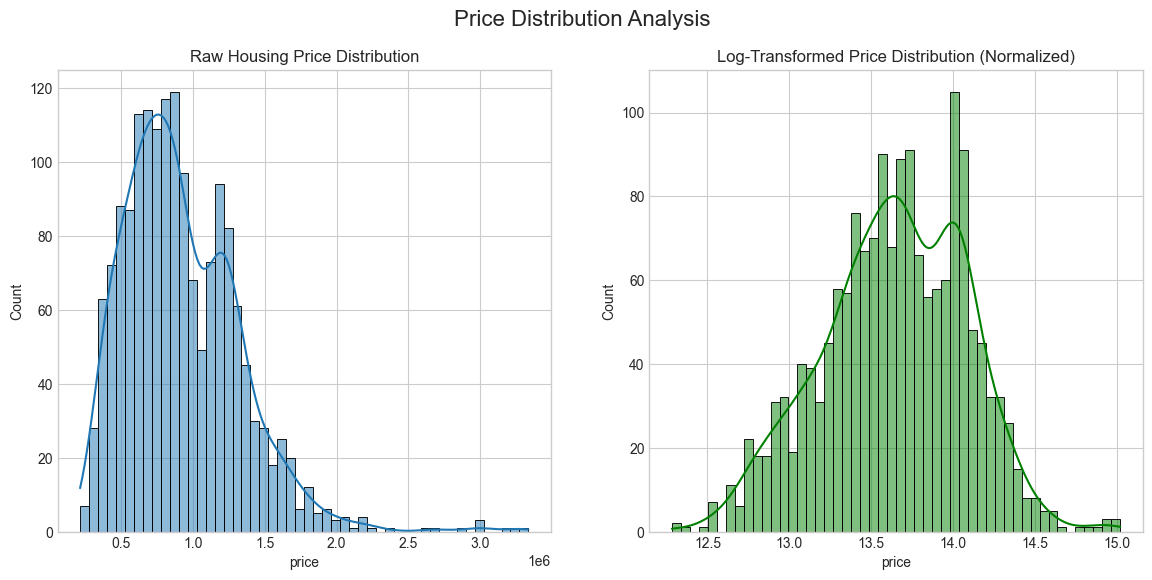

In [46]:
# --- Housing Price Distribution and Effect of Log Transformation ---
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_engineered['price'], kde=True, bins=50)
plt.title('Raw Housing Price Distribution')
plt.subplot(1, 2, 2)
sns.histplot(np.log1p(df_engineered['price']), kde=True, bins=50, color='green')
plt.title('Log-Transformed Price Distribution (Normalized)')
plt.suptitle('Price Distribution Analysis', fontsize=16)
plt.show()

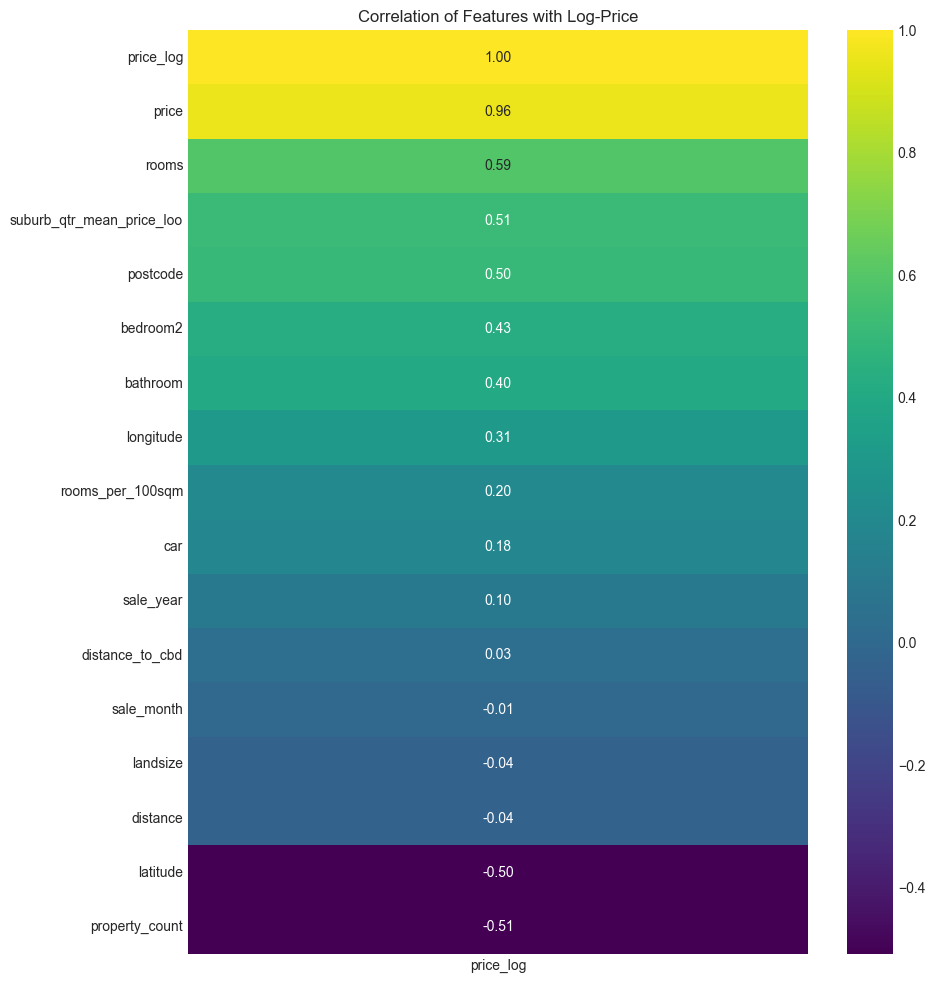

In [47]:
# --- Correlation of Numerical Features with House Price ---
corr_df = df_engineered.select_dtypes(include=np.number).copy()
corr_df['price_log'] = np.log1p(corr_df['price'])
plt.figure(figsize=(10, 12))
corr_matrix = corr_df.corr()[['price_log']].sort_values(by='price_log', ascending=False)
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title('Correlation of Features with Log-Price')
plt.show()

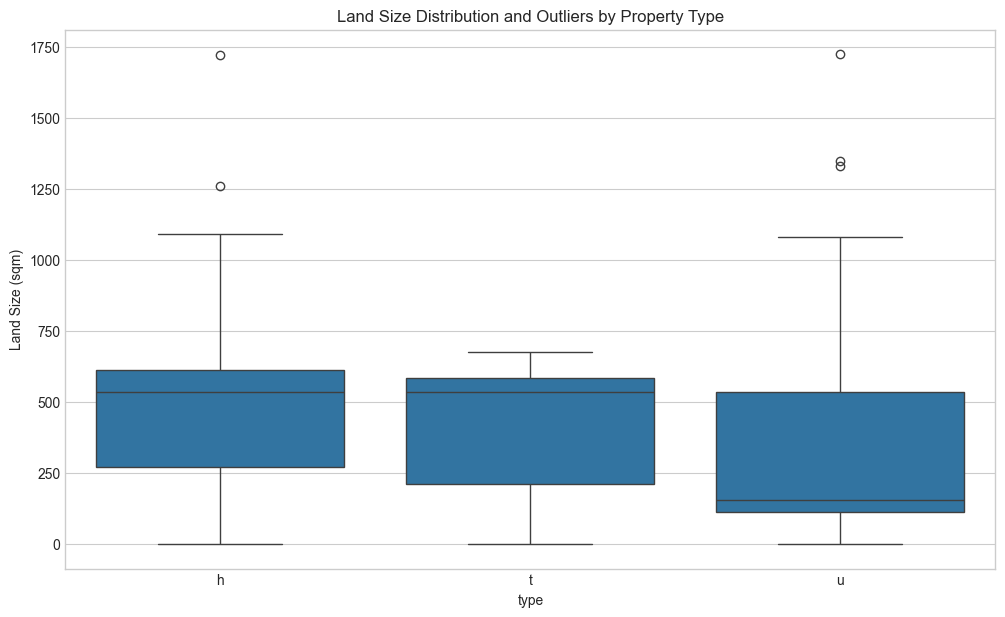

In [48]:
# --- Outlier Analysis for Land Size by Property Type ---
plt.figure(figsize=(12, 7))
df_filtered_land = df_engineered[df_engineered['landsize'] < 2000] 
sns.boxplot(x='type', y='landsize', data=df_filtered_land)
plt.title('Land Size Distribution and Outliers by Property Type')
plt.ylabel('Land Size (sqm)')
plt.show()

Generating Visualization 4: Scatter Plot...


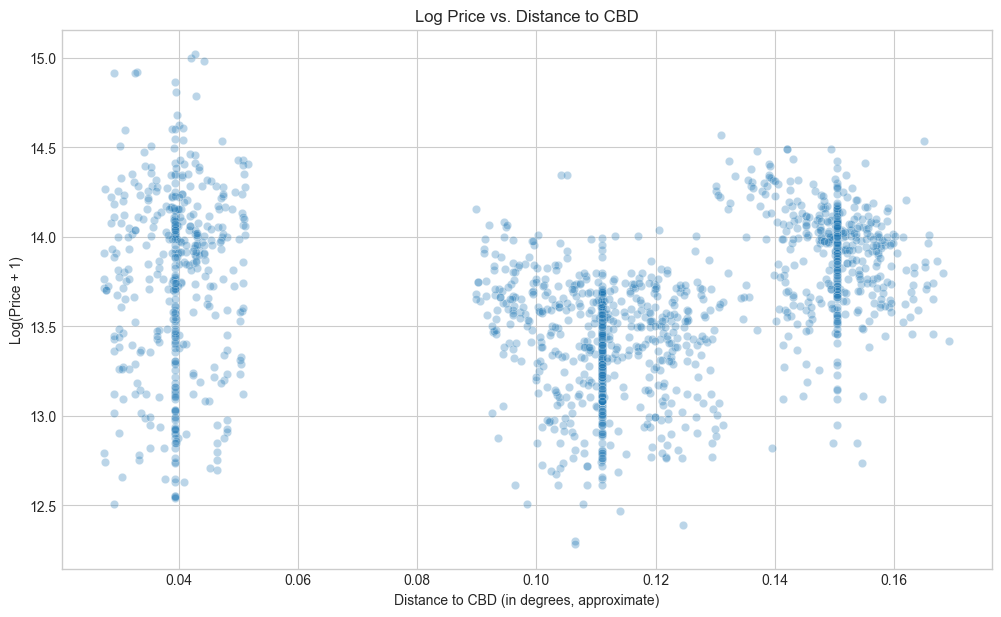

In [49]:
# --- Visualization 4: Scatter Plot of Price vs. a Key Feature ---
print("Generating Visualization 4: Scatter Plot...")
plt.figure(figsize=(12, 7))

# --- FIX: Create the necessary columns before plotting ---
df['price_log'] = np.log1p(df['price'])
df['distance_to_cbd'] = np.sqrt((df['latitude'] - (-37.8136))**2 + (df['longitude'] - (144.9631))**2)
# ---------------------------------------------------------

sns.scatterplot(x='distance_to_cbd', y='price_log', data=df, alpha=0.3)
plt.title('Log Price vs. Distance to CBD')
plt.xlabel('Distance to CBD (in degrees, approximate)')
plt.ylabel('Log(Price + 1)')
plt.grid(True)
plt.show()

Generating Visualization 5: Price Trends Line Plot...


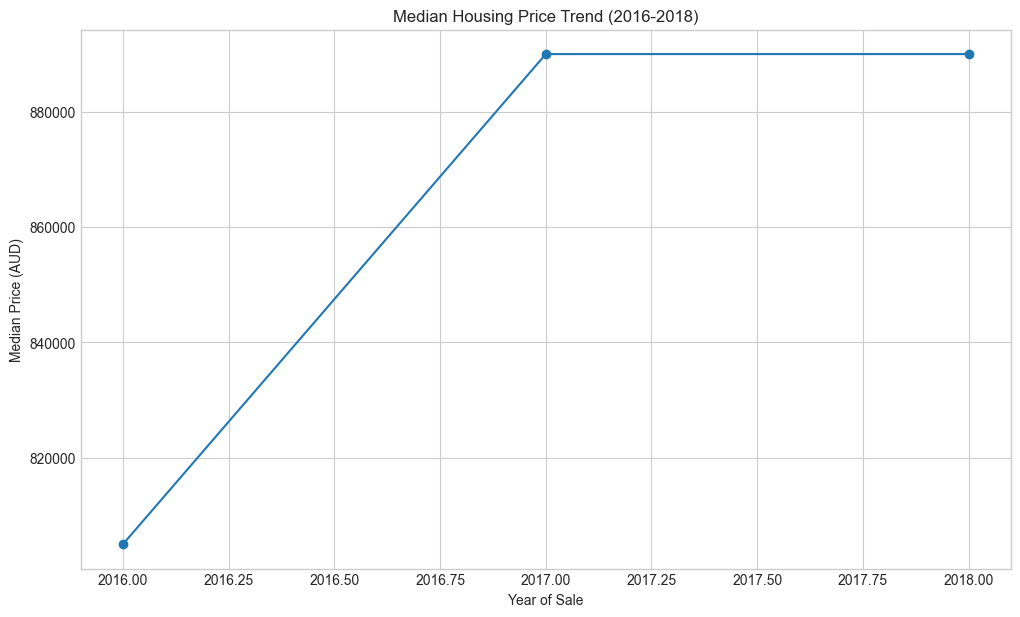

In [50]:
# --- Visualization 5: Price Trends Over Time ---
print("Generating Visualization 5: Price Trends Line Plot...")
plt.figure(figsize=(12, 7))

# --- FIX: Create the 'sale_year' column from the 'date' column ---
df['sale_year'] = pd.to_datetime(df['date']).dt.year
# -----------------------------------------------------------------

# Calculate the median price for each year and plot it
median_price_per_year = df.groupby('sale_year')['price'].median()
median_price_per_year.plot(kind='line', marker='o', linestyle='-')
plt.title('Median Housing Price Trend (2016-2018)')
plt.xlabel('Year of Sale')
plt.ylabel('Median Price (AUD)')
plt.grid(True)
plt.show()


Identifying quarterly trends for the top 3 suburbs: ['Reservoir', 'Bentleigh East', 'Richmond']

Generating Visualization: Quarterly Price Trends...


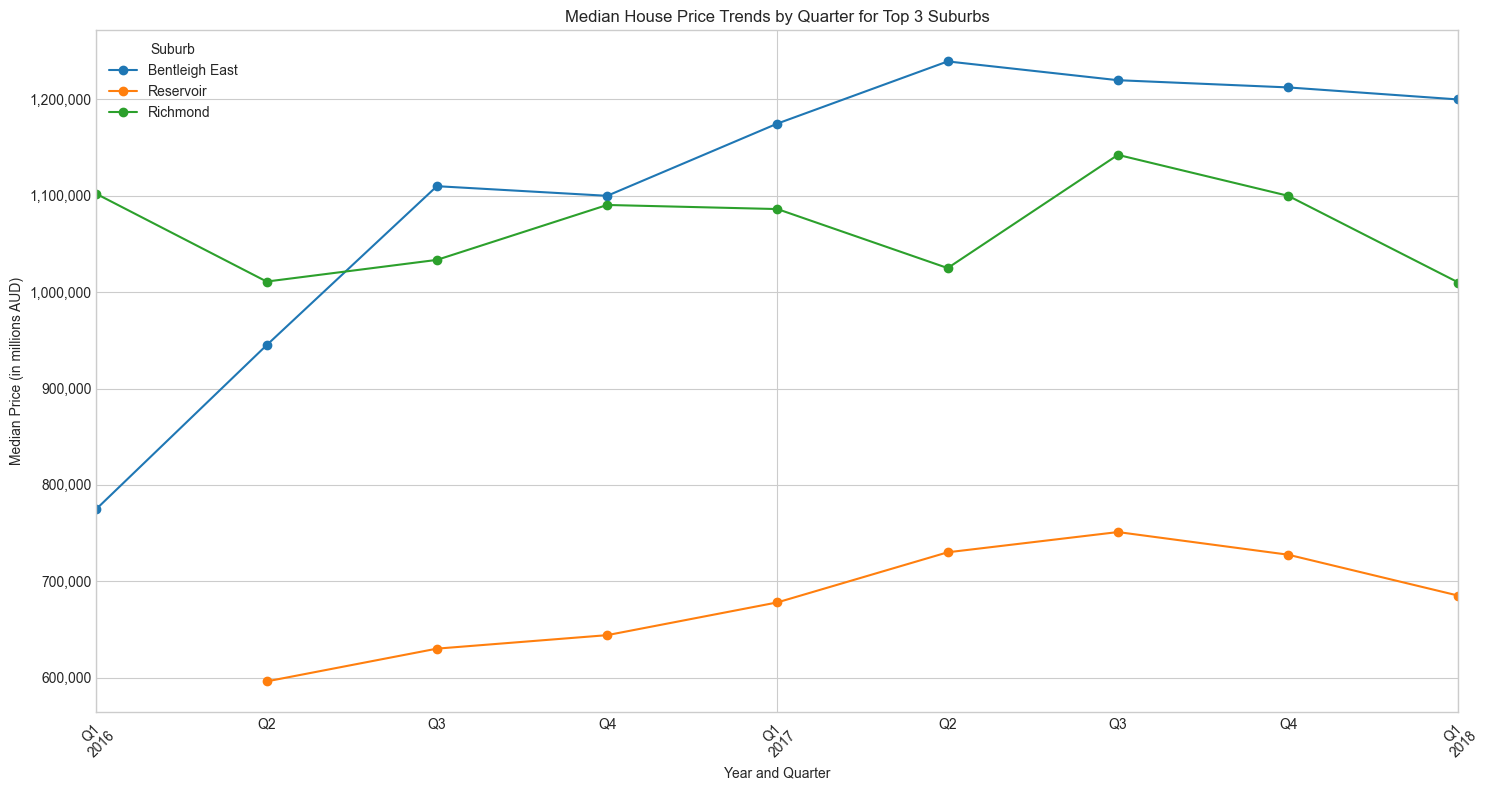


Median Quarterly Price Data Table:
suburb  Bentleigh East  Reservoir   Richmond
yr_qtr                                      
2016Q1        775000.0        NaN  1102000.0
2016Q2        945000.0   596000.0  1011000.0
2016Q3       1110000.0   630000.0  1033500.0
2016Q4       1100000.0   644000.0  1090500.0
2017Q1       1175000.0   678000.0  1086250.0


In [51]:
# Create a 'yr_qtr' column for grouping
# pd.PeriodIndex allows for easy sorting and plotting of time-based periods
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['yr_qtr'] = pd.PeriodIndex(df['date'], freq='Q')

# --- 3. Identify Top Suburbs ---
top_suburbs = df['suburb'].value_counts().nlargest(3).index
print(f"\nIdentifying quarterly trends for the top 3 suburbs: {list(top_suburbs)}")
df_top_suburbs = df[df['suburb'].isin(top_suburbs)]

# --- 4. Calculate Median Price Trends ---
# Group by the new 'yr_qtr' column and suburb, then find the median price
quarterly_price_trends = df_top_suburbs.groupby(['yr_qtr', 'suburb'])['price'].median().unstack()

# --- 5. Plot the Trends ---
print("\nGenerating Visualization: Quarterly Price Trends...")
plt.style.use('seaborn-v0_8-whitegrid')
quarterly_price_trends.plot(kind='line', figsize=(15, 8), marker='o', linestyle='-')

plt.title('Median House Price Trends by Quarter for Top 3 Suburbs')
plt.ylabel('Median Price (in millions AUD)')
plt.xlabel('Year and Quarter')
plt.legend(title='Suburb')
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.tight_layout()
plt.show()

# Display the underlying data table
print("\nMedian Quarterly Price Data Table:")
print(quarterly_price_trends.head())

In [52]:
# --- Prepare Data for Modeling ---
y = np.log1p(df_engineered['price'])
X = df_engineered.drop(columns=['price', 'suburb', 'seller_g', 'date', 'council_area', 'region_name'])
cat_cols = X.select_dtypes(include=["object","category"]).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# --- Create the Full Preprocessing Pipeline ---
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', Pipeline([('imp', SimpleImputer(strategy="most_frequent")), ('ohe', OneHotEncoder(handle_unknown="ignore", sparse_output=False))]), cat_cols),
        ('num', Pipeline([('imp', SimpleImputer(strategy="median")), ('scaler', StandardScaler())]), num_cols)
    ], remainder="drop"
)

# --- Define Models and Evaluate ---
models = {
    "RandomForest": Pipeline([('prep', preprocessor), ('model', RandomForestRegressor(n_estimators=500, max_depth=20, random_state=42, n_jobs=-1))]),
    "GradBoost": Pipeline([('prep', preprocessor), ('model', GradientBoostingRegressor(n_estimators=700, learning_rate=0.03, max_depth=5, random_state=42))]),
    "HistGradBoost": Pipeline([('prep', preprocessor), ('model', HistGradientBoostingRegressor(learning_rate=0.05, max_leaf_nodes=31, random_state=42))]),
    "XGBoost": Pipeline([('prep', preprocessor), ('model', XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=7, random_state=42, n_jobs=-1))])
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = []
for name, pipe in models.items():
    fold_scores = {'MAE': [], 'RMSE': [], 'R-squared': []}
    for train_idx, test_idx in kf.split(X, y):
        X_train, X_test, y_train, y_test = X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]
        pipe.fit(X_train, y_train)
        y_pred_log = pipe.predict(X_test)
        y_test_orig, y_pred_orig = np.expm1(y_test), np.expm1(y_pred_log)
        fold_scores['MAE'].append(mean_absolute_error(y_test_orig, y_pred_orig))
        fold_scores['RMSE'].append(np.sqrt(mean_squared_error(y_test_orig, y_pred_orig)))
        fold_scores['R-squared'].append(r2_score(y_test, y_pred_log))
    
    results.append({
        'Model': name,
        'MAE': f"${np.mean(fold_scores['MAE']):,.0f} (± ${np.std(fold_scores['MAE']):,.0f})",
        'RMSE': f"${np.mean(fold_scores['RMSE']):,.0f} (± ${np.std(fold_scores['RMSE']):,.0f})",
        'R-squared': f"{np.mean(fold_scores['R-squared']):.4f} (± {np.std(fold_scores['R-squared']):.4f})"
    })

# --- Display results in a clean table ---
results_df = pd.DataFrame(results)

# By having the DataFrame as the last line, Jupyter will render it as a nice table
results_df

,Model,MAE,RMSE,R-squared
0,RandomForest,"$103,567 (± $3,653)","$177,452 (± $21,449)",0.8583 (± 0.0188)
1,GradBoost,"$99,495 (± $4,205)","$170,493 (± $22,492)",0.8714 (± 0.0111)
2,HistGradBoost,"$109,359 (± $4,060)","$180,352 (± $24,409)",0.8558 (± 0.0152)
3,XGBoost,"$98,003 (± $3,863)","$169,371 (± $23,469)",0.8694 (± 0.0200)


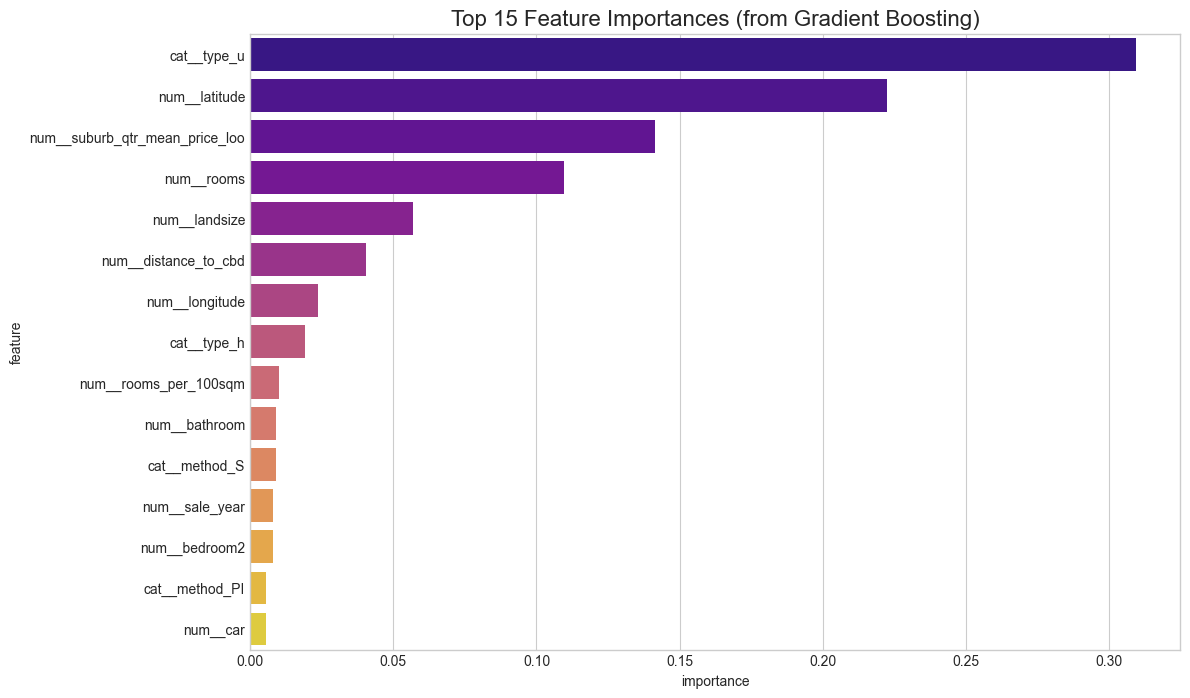

In [53]:
# --- Select and Train the Best Model for Analysis ---
best_model_pipeline = models['GradBoost']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
best_model_pipeline.fit(X_train, y_train)

# --- Visualization 1: Model-Specific Feature Importance ---
feature_names = best_model_pipeline.named_steps['prep'].get_feature_names_out()
importances = best_model_pipeline.named_steps['model'].feature_importances_
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values('importance', ascending=False).head(15)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=importance_df, palette='plasma')
plt.title('Top 15 Feature Importances (from Gradient Boosting)', fontsize=16)
plt.show()


SHAP Summary Plot: Shows feature importance and impact on predictions.


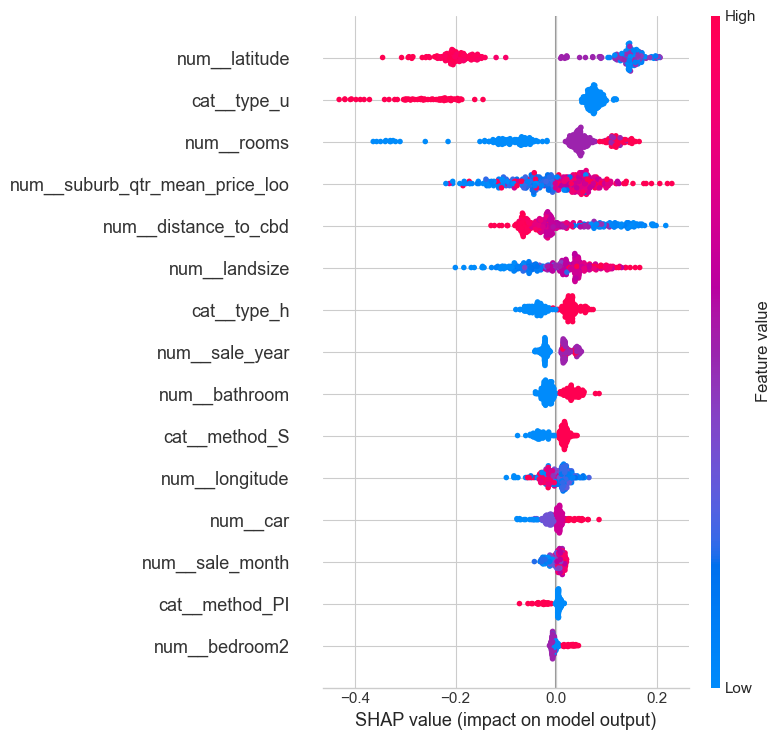

In [54]:
# --- Prepare Data and Explainer for SHAP ---
X_test_transformed = best_model_pipeline.named_steps['prep'].transform(X_test)
feature_names_transformed = best_model_pipeline.named_steps['prep'].get_feature_names_out()
explainer = shap.TreeExplainer(best_model_pipeline.named_steps['model'])
shap_values = explainer.shap_values(X_test_transformed)

# --- Visualization 2: SHAP Summary Plot ---
print("\nSHAP Summary Plot: Shows feature importance and impact on predictions.")
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names_transformed, max_display=15)


SHAP Dependence Plot for 'suburb_qtr_mean_price_loo'


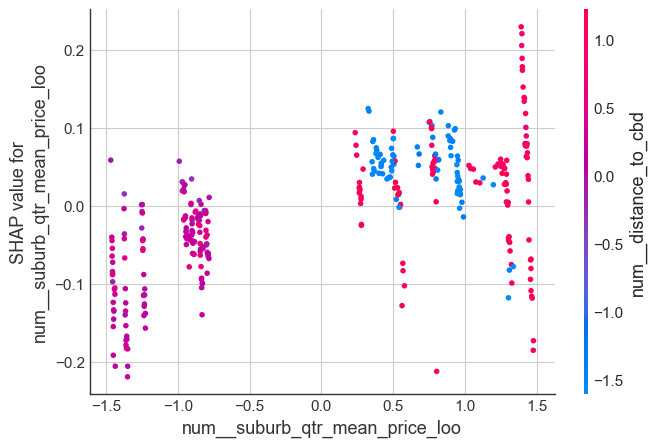

In [55]:
# --- Visualization 3: SHAP Dependence Plot ---
print("\nSHAP Dependence Plot for 'suburb_qtr_mean_price_loo'")
# SHAP requires a DataFrame for some plotting features
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names_transformed)

shap.dependence_plot(
    'num__suburb_qtr_mean_price_loo',
    shap_values,
    X_test_transformed_df,
    interaction_index='num__distance_to_cbd' # Color points by another feature
)


Calculating Permutation Importance...


<Figure size 1200x800 with 0 Axes>

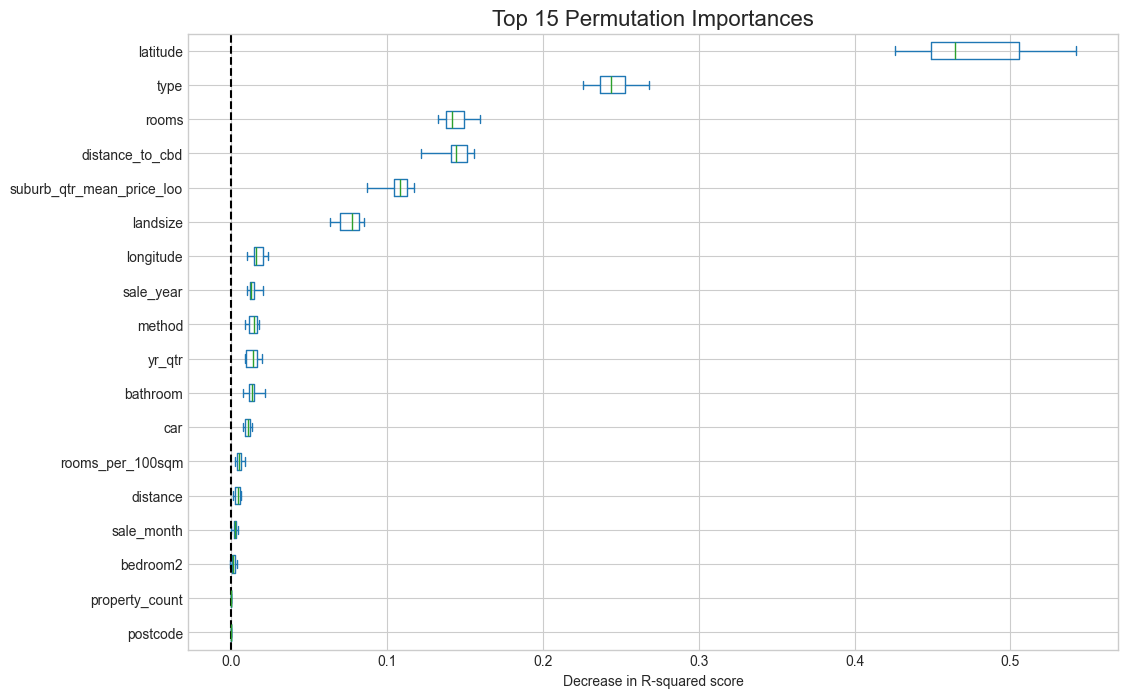

In [56]:
# --- Visualization 4: Permutation Importance ---
print("\nCalculating Permutation Importance...")
perm_importance = permutation_importance(
    best_model_pipeline, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)
sorted_idx = perm_importance.importances_mean.argsort()
perm_df = pd.DataFrame(
    perm_importance.importances[sorted_idx].T,
    columns=X.columns[sorted_idx]
).tail(15)

plt.figure(figsize=(12, 8))
perm_df.plot(kind='box', vert=False, whis=10, figsize=(12, 8))
plt.title('Top 15 Permutation Importances', fontsize=16)
plt.xlabel('Decrease in R-squared score')
plt.axvline(x=0, color='k', linestyle='--')
plt.show()


Calculating SHAP Interaction Values...

SHAP Interaction Plot: Shows which features have the strongest interaction effects.


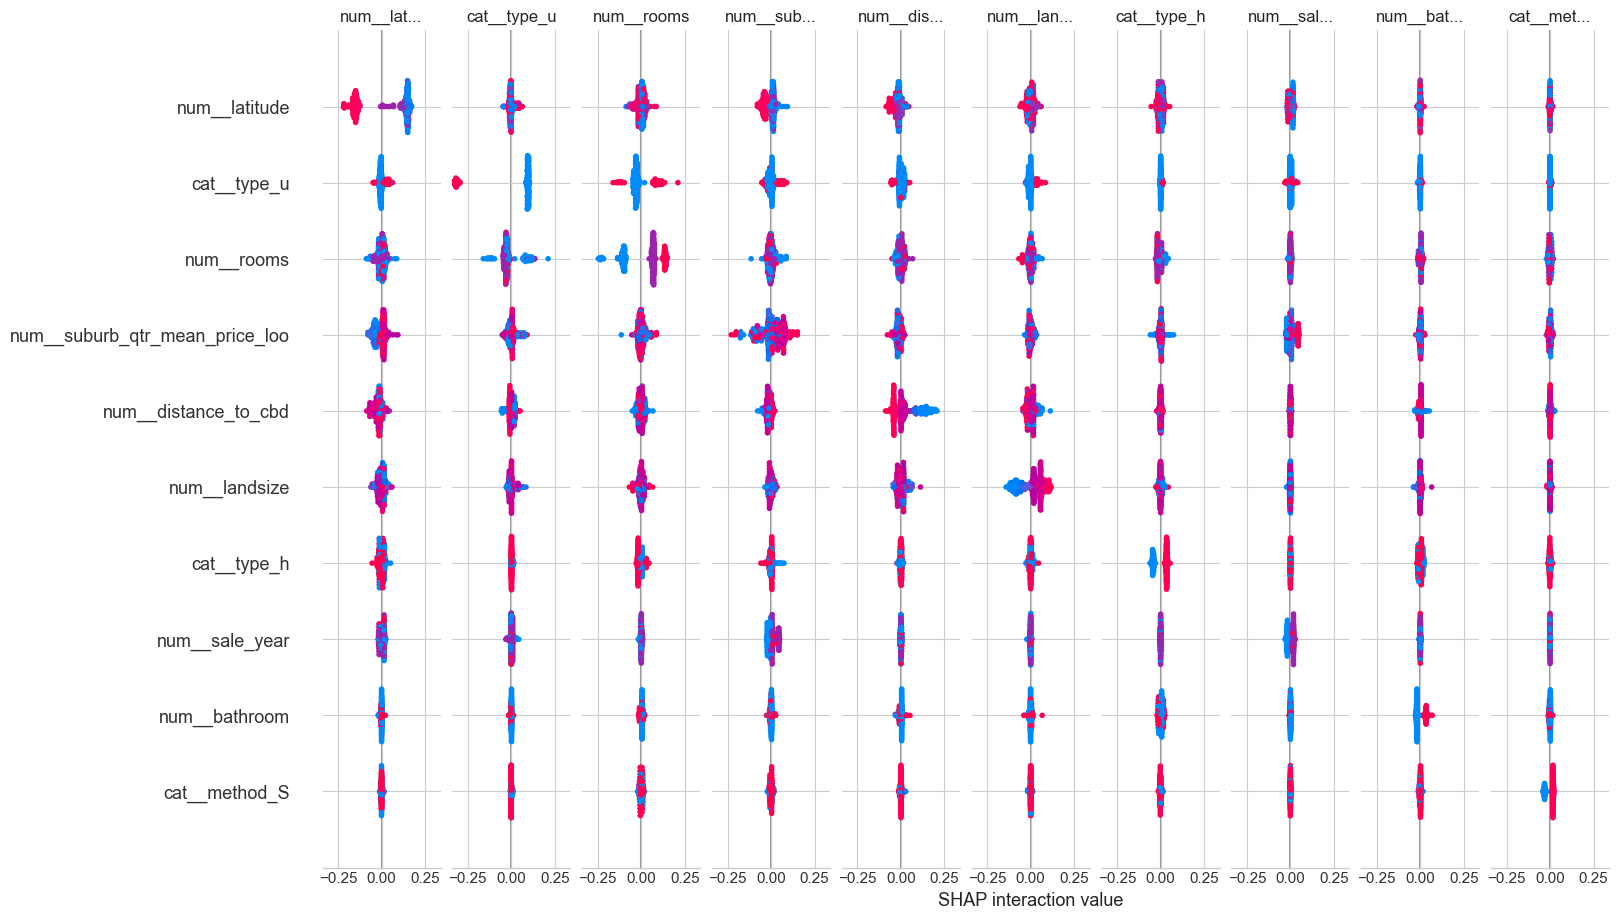

In [57]:
# --- Visualization 5: SHAP Interaction Values Summary ---
print("\nCalculating SHAP Interaction Values...")
shap_interaction_values = explainer.shap_interaction_values(X_test_transformed)

print("\nSHAP Interaction Plot: Shows which features have the strongest interaction effects.")
shap.summary_plot(shap_interaction_values, X_test_transformed, max_display=10, feature_names=feature_names_transformed)

Training final model on the training data...
Making predictions on the held-out test set...


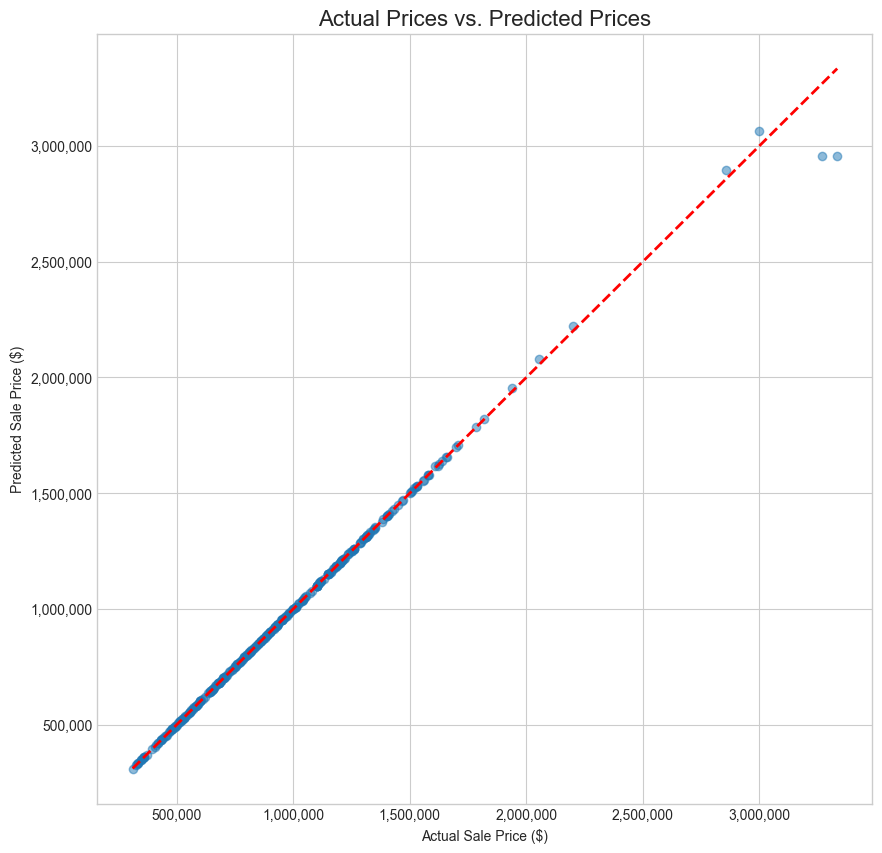

In [58]:
def advanced_feature_engineer(dataframe):
    df_eng = dataframe.copy()
    df_eng['date'] = pd.to_datetime(df_eng['date'], errors='coerce')
    df_eng.dropna(subset=['date'], inplace=True)
    df_eng['sale_year'] = df_eng['date'].dt.year
    df_eng['sale_month'] = df_eng['date'].dt.month
    cbd_lat, cbd_lon = -37.8136, 144.9631
    df_eng['distance_to_cbd'] = np.sqrt((df_eng['latitude'] - cbd_lat)**2 + (df_eng['longitude'] - cbd_lon)**2)
    landsize_no_zero = df_eng['landsize'].replace(0, np.nan)
    df_eng['rooms_per_100sqm'] = (df_eng['rooms'] / landsize_no_zero) * 100
    df_eng['yr_qtr'] = df_eng['date'].dt.to_period('Q').astype(str)
    group_key = ['suburb', 'yr_qtr']
    grouped = df_eng.groupby(group_key)['price'].agg(['sum', 'count'])
    df_eng = pd.merge(df_eng, grouped, on=group_key, how='left')
    df_eng['suburb_qtr_mean_price_loo'] = (df_eng['sum'] - df_eng['price']) / (df_eng['count'] - 1)
    yearly_mean_price = df_eng.groupby('sale_year')['price'].transform('mean')
    df_eng['suburb_qtr_mean_price_loo'] = df_eng['suburb_qtr_mean_price_loo'].fillna(yearly_mean_price)
    df_eng = df_eng.drop(columns=['sum', 'count'])
    return df_eng

df_engineered = advanced_feature_engineer(df)

y = np.log1p(df_engineered['price'])
X = df_engineered.drop(columns=['price', 'suburb', 'seller_g', 'date', 'council_area', 'region_name'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 2. Train the Final Model ---
# We will use the best model, Gradient Boosting
final_model_pipeline = Pipeline([
    ('prep', ColumnTransformer(
        transformers=[
            ('cat', Pipeline([('imp', SimpleImputer(strategy='most_frequent')), ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]), X.select_dtypes(include=["object","category"]).columns.tolist()),
            ('num', Pipeline([('imp', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), X.select_dtypes(include=np.number).columns.tolist())
        ],
        remainder='drop'
    )),
    ('model', GradientBoostingRegressor(n_estimators=700, learning_rate=0.03, max_depth=5, subsample=0.7, random_state=42))
])

print("Training final model on the training data...")
final_model_pipeline.fit(X_train, y_train)

# --- 3. Make Predictions and Visualize ---
print("Making predictions on the held-out test set...")
y_pred_log = final_model_pipeline.predict(X_test)

# Convert both true and predicted values back to original dollar amounts
y_test_actual_dollars = np.expm1(y_test)
y_pred_actual_dollars = np.expm1(y_pred_log)

# Create the scatter plot
plt.figure(figsize=(10, 10))
plt.scatter(y_test_actual_dollars, y_pred_actual_dollars, alpha=0.5)
plt.plot([min(y_test_actual_dollars), max(y_test_actual_dollars)], 
         [min(y_test_actual_dollars), max(y_test_actual_dollars)], 
         'r--', lw=2) # Add a dashed red line for reference (perfect prediction)
plt.title('Actual Prices vs. Predicted Prices', fontsize=16)
plt.xlabel('Actual Sale Price ($)')
plt.ylabel('Predicted Sale Price ($)')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.grid(True)
plt.show()